In [1]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from firedrake.meshadapt import *
import ufl
import numpy as np
from firedrake import UnitSquareMesh,FunctionSpace,VectorFunctionSpace,SpatialCoordinate 

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, start from simple case(Poisson Equation): 

$
-\nabla^2 u + u  = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma,
$

with:

$
f(x, y) = (1.0 + 8.0\pi^2)\cos(2\pi x)\cos(2\pi y).
$

This conveniently yields the analytical solution:

$
u(x, y) = \cos(2\pi x)\cos(2\pi y).
$

In [2]:
# Define mesh and function space
mesh = UnitSquareMesh(64, 64)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

x, y = SpatialCoordinate(mesh)

# Define analytical solution and right-hand side
u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
f = Function(P1)
f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

# Define variational problem
u = TrialFunction(P1)
v = TestFunction(P1)
a = dot(grad(u), grad(v))*dx + u*v*dx
L = f*v*dx

# Compute solution for Poisson equation
u_sol = Function(P1)
solve(a == L, u_sol)

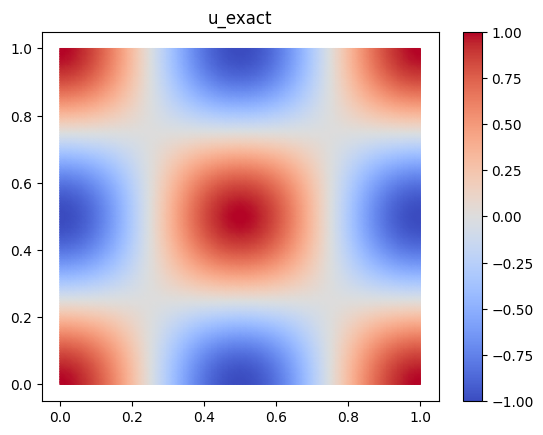

In [8]:
fig, axes = plt.subplots()
u_exact_plt = tripcolor(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_exact_plt)
plt.title("u_exact")
plt.show()


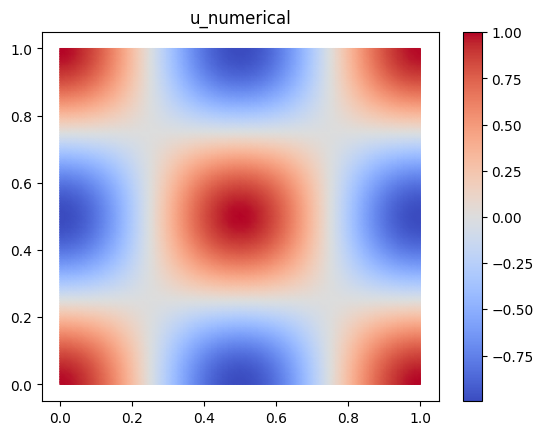

In [9]:
fig, axes = plt.subplots()
u_num_plt = tripcolor(u_sol, axes=axes, cmap='coolwarm')
fig.colorbar(u_num_plt)
plt.title("u_numerical")
plt.show()

In [10]:
# Calculate analytical gradient of u
u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
u_grad_exact = project(u_grad_exact_expr, P1_vec)

In [11]:
# Define class for L2 projector
class L2Projector:
    def __init__(self, mesh, P1_vec, phi_old,**kwargs):
        self.mesh = mesh
        self.P1_vec = P1_vec
        self.phi_old = phi_old
        self.dim = mesh.geometric_dimension()
        self._grad_phi = Function(P1_vec)

        # Measures
        degree = kwargs.get('quadrature_degree')
        self.dx = dx(domain=mesh, degree=degree)
        self.ds = ds(domain=mesh, degree=degree)
        self.dS = dS(domain=mesh, degree=degree)
        self.fix_boundary_nodes = kwargs.pop('fix_boundary_nodes', False)

    # Include the l2_projector code you provided
    @property
    def l2_projector(self):
        if hasattr(self, '_l2_projector'):
            return self._l2_projector
        u_cts = TrialFunction(self.P1_vec)
        v_cts = TestFunction(self.P1_vec)
        n = FacetNormal(mesh)

        # Domain interior
        phi_grad_v_dx = self.phi_old*dot(v_cts, n)*ds-ufl.inner(self.phi_old, ufl.div(v_cts))*self.dx
        a = ufl.inner(v_cts, u_cts)*self.dx
        L = phi_grad_v_dx

        # Enforce no movement normal to boundary
        n = ufl.FacetNormal(self.mesh)
        bcs = []
        for i in self.mesh.exterior_facets.unique_markers:
            if self.fix_boundary_nodes:
                bcs.append(DirichletBC(self.P1_vec, 0, i))
                continue

            # Check for axis-aligned boundaries
            _n = [assemble(abs(n[j])*self.ds(i)) for j in range(self.dim)]
            if np.allclose(_n, 0.0):
                raise ValueError(f"Invalid normal vector {_n}")
            else:
                if np.isclose(_n[0], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(1), 0, i))
                    continue
                elif np.isclose(_n[1], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(0), 0, i))
                    continue

            a_bc = ufl.dot(v_cts, n)*ufl.dot(u_cts, n)*self.ds
            bcs.append(EquationBC(a_bc == 0, self._grad_phi, i))

            s = ufl.perp(n)
            a_bc = ufl.dot(v_cts, s)*ufl.dot(u_cts, s)*self.ds
            L_bc = ufl.dot(v_cts, s)*phi_grad_v_dx
            bcs.append(EquationBC(a_bc == L_bc, self._grad_phi, i))

        # Create solver
        problem = LinearVariationalProblem(a, L, self._grad_phi, bcs=None)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._l2_projector = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._l2_projector

# Use the solution of the Poisson equation as phi_old
projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

# Call L2 projector and get result
l2_projector = projector.l2_projector
l2_projector.solve()

# Compare L2 projected gradient with analytical gradient
u_grad_l2 = projector._grad_phi
u_grad_diff = project(u_grad_l2 - u_grad_exact, P1_vec)


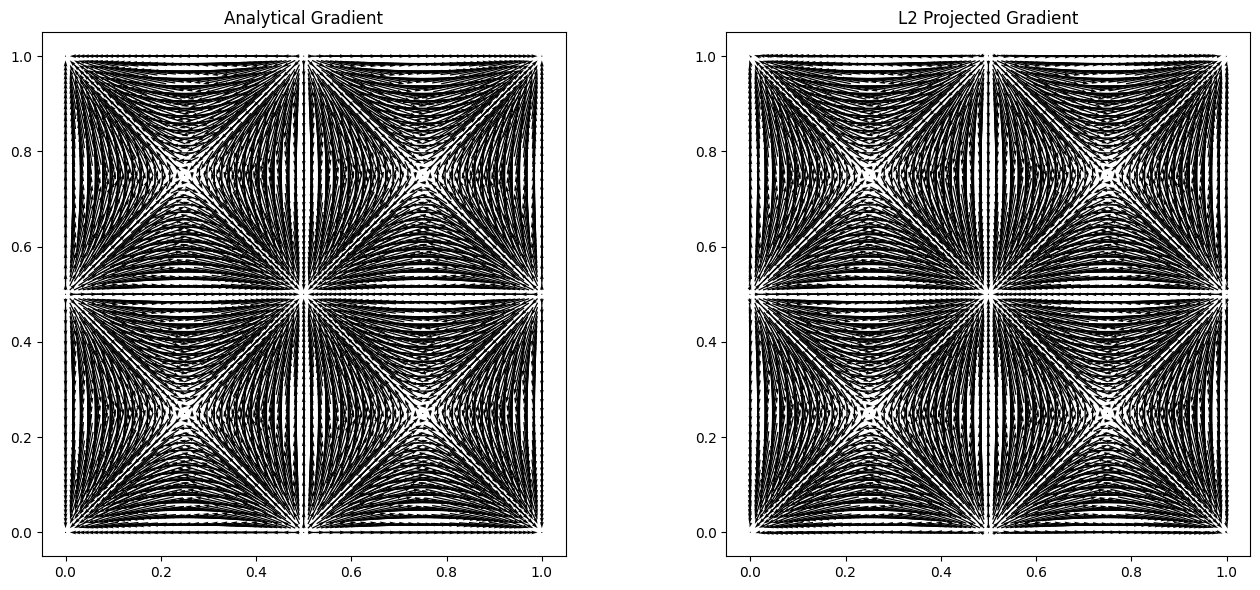

In [12]:
# Plot
# To visualize vectors using quiver plot
coords = mesh.coordinates.dat.data
u_vals_exact = u_grad_exact.dat.data
u_vals_l2 = u_grad_l2.dat.data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Quiver plot for analytical gradient
axes[0].quiver(coords[:, 0], coords[:, 1], u_vals_exact[:, 0], u_vals_exact[:, 1], pivot='middle', scale=50)
axes[0].set_title('Analytical Gradient')
axes[0].set_aspect('equal')

# Quiver plot for L2 projected gradient
axes[1].quiver(coords[:, 0], coords[:, 1], u_vals_l2[:, 0], u_vals_l2[:, 1], pivot='middle', scale=50)
axes[1].set_title('L2 Projected Gradient')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [13]:
# Compute the magnitudes of the gradients
u_grad_diff = Function(P1_vec).interpolate(u_grad_l2 - u_grad_exact)
u_grad_diff_norm = Function(P1).interpolate(sqrt(dot(u_grad_diff, u_grad_diff)))


In [14]:
u_grad_diff_norm_max = max(u_grad_diff_norm.dat.data)
u_grad_diff_norm_min = min(u_grad_diff_norm.dat.data)
print("The norm of difference is %.2f to %.2f" % (u_grad_diff_norm_min, u_grad_diff_norm_max))

The norm of difference is 0.00 to 0.31


In [15]:
u_grad_diff_global = sum(u_grad_diff_norm.dat.data)
print("The global error is %.2f" % (u_grad_diff_global))

The global error is 112.34
